In [ ]:
# Install dependencies
!pip install pyspark datasets -q

In [ ]:
# Stream from Hugging Face & filter by cell_line_id

from datasets import load_dataset
from itertools import islice
import json

# Define cell lines
target_cell_line_ids = {
    "CVCL_0131",  # A-172
    "CVCL_0021",  # U-251MG
    "CVCL_0022",  # U-87MG
    "CVCL_S471",  # U-343MG
    "CVCL_5735",  # D-54MG
    "CVCL_1239",  # H4
    "CVCL_RU29"   # BT048
}

# Stream dataset
dataset = load_dataset("vevotx/Tahoe-100M", split="train", streaming=True)

# Filter and save to JSON Lines file to use for spark
max_records = 5000  # adjust based on Colab memory (50k works with Pro)
output_path = "tahoe_filtered.jsonl"

with open(output_path, "w") as f:
    for sample in islice((x for x in dataset if x.get("cell_line_id") in target_cell_line_ids), max_records):
        f.write(json.dumps(sample) + "\n")

print(f"Saved {max_records} filtered records to {output_path}")


Resolving data files:   0%|          | 0/3388 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3388 [00:00<?, ?it/s]

Saved 5000 filtered records to tahoe_filtered.jsonl


In [ ]:
#Initialize Spark and load data

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TahoeExploration").getOrCreate()

# Load JSONL file as Spark DataFrame
df = spark.read.json("tahoe_filtered.jsonl")

# Show schema and a few rows
df.printSchema()
df.show(5, truncate=False)


root
 |-- BARCODE_SUB_LIB_ID: string (nullable = true)
 |-- canonical_smiles: string (nullable = true)
 |-- cell_line_id: string (nullable = true)
 |-- drug: string (nullable = true)
 |-- expressions: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- genes: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- moa-fine: string (nullable = true)
 |-- plate: string (nullable = true)
 |-- pubchem_cid: string (nullable = true)
 |-- sample: string (nullable = true)

+-------------------+------------------------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col, when, count
# Basic Exploration

# Count total records
print("Total records:", df.count())

# Distinct cell lines
df.select("cell_line_id").distinct().show(truncate=False)

# Drug type distribution
df.groupBy("drug").count().show()

# Count nulls across all columns
null_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])

# Show all nulls
null_counts.show()



Total records: 5000
+------------+
|cell_line_id|
+------------+
|CVCL_1239   |
|CVCL_0131   |
+------------+

+--------------------+-----+
|                drug|count|
+--------------------+-----+
|        Temsirolimus|   83|
|           Adagrasib|   53|
|            Bergenin|   53|
|Palmatine (chloride)|   93|
|L-Thyroxine (sodi...|   42|
|         Resveratrol|   43|
|      Demeclocycline|   37|
|          Olanzapine|   49|
|       Sulfisoxazole|   44|
|      Salicylic acid|   64|
|            Busulfan|   33|
|          Artesunate|   46|
|Clonidine (hydroc...|   65|
|Chlorhexidine (di...|   79|
|        Fusidic acid|   60|
|       Triamcinolone|   26|
|(R)-Verapamil (hy...|  100|
|          Vilanterol|   46|
|          Quinestrol|   92|
|Fluvoxamine (male...|   49|
+--------------------+-----+
only showing top 20 rows

+------------------+----------------+------------+----+-----------+-----+--------+-----+-----------+------+
|BARCODE_SUB_LIB_ID|canonical_smiles|cell_line_id|drug|expr

Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.

In [ ]:
print(f"Number of Rows: {df.count()}")
print(f"Number of Columns: {len(df.columns)}")


Number of Rows: 5000
Number of Columns: 10


In [ ]:
df.printSchema()


root
 |-- BARCODE_SUB_LIB_ID: string (nullable = true)
 |-- canonical_smiles: string (nullable = true)
 |-- cell_line_id: string (nullable = true)
 |-- drug: string (nullable = true)
 |-- expressions: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- genes: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- moa-fine: string (nullable = true)
 |-- plate: string (nullable = true)
 |-- pubchem_cid: string (nullable = true)
 |-- sample: string (nullable = true)



In [ ]:
df.describe().show() #numerical col


+-------+-------------------+--------------------+------------+--------------------+--------+------+--------------------+--------+
|summary| BARCODE_SUB_LIB_ID|    canonical_smiles|cell_line_id|                drug|moa-fine| plate|         pubchem_cid|  sample|
+-------+-------------------+--------------------+------------+--------------------+--------+------+--------------------+--------+
|  count|               5000|                5000|        5000|                5000|    5000|  5000|                5000|    5000|
|   mean|               NULL|                NULL|        NULL|                NULL|    NULL|  NULL| 1.539430479348269E7|    NULL|
| stddev|               NULL|                NULL|        NULL|                NULL|    NULL|  NULL|3.2466779046315033E7|    NULL|
|    min|01_001_034-lib_1107|                    |   CVCL_0131|(R)-Verapamil (hy...|        |plate4|                    |smp_1783|
|    max|96_191_026-lib_1105|C[C@]12CC[C@](C[C...|   CVCL_1239|Vinblastine (sulf...

In [ ]:
for c in ['drug', 'cell_line_id', 'moa-fine', 'plate']:
    df.groupBy(c).count().orderBy('count', ascending=False).show(10, truncate=False) #counts of unique values


+-----------------------------+-----+
|drug                         |count|
+-----------------------------+-----+
|(R)-Verapamil (hydrochloride)|100  |
|Aliskiren                    |97   |
|Palmatine (chloride)         |93   |
|Quinestrol                   |92   |
|DMSO_TF                      |90   |
|Isocorydine                  |87   |
|Megestrol                    |87   |
|Pasireotide (acetate)        |85   |
|Terfenadine                  |85   |
|Temsirolimus                 |83   |
+-----------------------------+-----+
only showing top 10 rows

+------------+-----+
|cell_line_id|count|
+------------+-----+
|CVCL_0131   |3946 |
|CVCL_1239   |1054 |
+------------+-----+

+------------------------------+-----+
|moa-fine                      |count|
+------------------------------+-----+
|unclear                       |3379 |
|DNA synthesis/repair inhibitor|341  |
|Cyclooxygenase inhibitor      |195  |
|JAK/STAT inhibitor            |187  |
|MTOR inhibitor                |154  |
|Ad

In [ ]:
from pyspark.sql.functions import size
#checking to see if expressions size = genes size bc apparently that is important
df.select(size("expressions").alias("expressions_length"), size("genes").alias("genes_length")).describe().show()


+-------+------------------+------------------+
|summary|expressions_length|      genes_length|
+-------+------------------+------------------+
|  count|              5000|              5000|
|   mean|         1135.5434|         1135.5434|
| stddev|422.84097083154415|422.84097083154415|
|    min|               464|               464|
|    max|              3658|              3658|
+-------+------------------+------------------+



In [ ]:
df.select((size("expressions") == size("genes")).alias("matching")).groupBy("matching").count().show()


+--------+-----+
|matching|count|
+--------+-----+
|    true| 5000|
+--------+-----+



#Expressions Values Stats
##Explode the expressions arrays

In [ ]:
# 4. Expressions Values Stats
# Explode the expressions arrays

import scipy.stats
from pyspark.sql.functions import explode
expressions_exploded = df.select(explode("expressions").alias("expression_value"))

# Describe the expressions
expr_stats = expressions_exploded.describe()
expr_stats.show()

# Mean, Median, Stddev (in Pandas for flexibility)
expr_pd = expressions_exploded.toPandas()

expr_mean = expr_pd['expression_value'].mean()
expr_median = expr_pd['expression_value'].median()
expr_std = expr_pd['expression_value'].std()
expr_skew = scipy.stats.skew(expr_pd['expression_value'].dropna())

print(f"Expression Mean: {expr_mean:.4f}")
print(f"Expression Median: {expr_median:.4f}")
print(f"Expression Std: {expr_std:.4f}")
print(f"Expression Skewness: {expr_skew:.4f}")

+-------+------------------+
|summary|  expression_value|
+-------+------------------+
|  count|           5677717|
|   mean|1.4124613819251646|
| stddev|3.0972319226355016|
|    min|              -2.0|
|    max|             399.0|
+-------+------------------+

Expression Mean: 1.4125
Expression Median: 1.0000
Expression Std: 3.0972
Expression Skewness: 32.9372


# **Categorical Columns - Top Categories**

In [ ]:
# Categorical Columns - Top Categories
def top_categories(col_name):
    df.groupBy(col_name).count().orderBy('count', ascending=False).show(5, truncate=False)

print("\nTop Drugs:")
top_categories('drug')

print("\nTop Cell Lines:")
top_categories('cell_line_id')

print("\nTop Mechanisms of Action:")
top_categories('moa-fine')



Top Drugs:
+-----------------------------+-----+
|drug                         |count|
+-----------------------------+-----+
|(R)-Verapamil (hydrochloride)|100  |
|Aliskiren                    |97   |
|Palmatine (chloride)         |93   |
|Quinestrol                   |92   |
|DMSO_TF                      |90   |
+-----------------------------+-----+
only showing top 5 rows


Top Cell Lines:
+------------+-----+
|cell_line_id|count|
+------------+-----+
|CVCL_0131   |3946 |
|CVCL_1239   |1054 |
+------------+-----+


Top Mechanisms of Action:
+------------------------------+-----+
|moa-fine                      |count|
+------------------------------+-----+
|unclear                       |3379 |
|DNA synthesis/repair inhibitor|341  |
|Cyclooxygenase inhibitor      |195  |
|JAK/STAT inhibitor            |187  |
|MTOR inhibitor                |154  |
+------------------------------+-----+
only showing top 5 rows



## **DISTRIBUTIONS**

We mainly need histograms for gene expression values and expression array lengths. The histogram of the number of genes per sample appears to be right skewed. The majority of the data lie between 600 to 1400 genes and the range stretches from 464 to 3658.

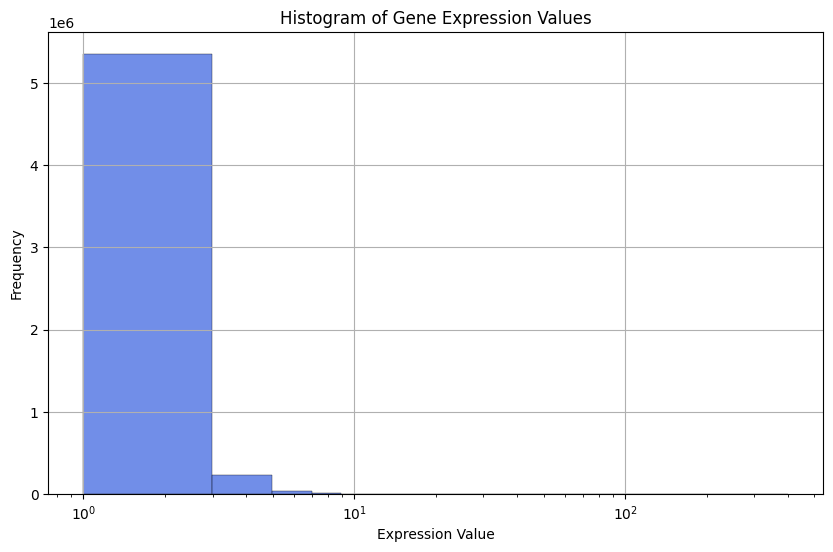

In [ ]:
#IS THIS HISTOGRAM RIGHT? PLS INQUIRE NICK
pdf = df.limit(5000).toPandas()  # recreated Pandas DataFrame from Spark and defined pdf for the error at a 5000 limit
all_expressions = []
for expr_list in pdf['expressions'].dropna():
    all_expressions.extend(expr_list)

plt.figure(figsize=(10, 6))
sns.histplot([x for x in all_expressions if x > 0], bins=200, kde=False, color='royalblue')
plt.xscale('log')
plt.title('Histogram of Gene Expression Values')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram displays the distribution of positive gene expression values on a logarithmic x-axis. The majority of expression values are tightly concentrated between 1 and 10, with a sharp drop-off in frequency as expression levels increase beyond 10. Very few genes show expression values above 10, and almost none beyond 100. The log-scale x-axis highlights the heavy skew toward low expression values, typical in gene expression datasets where most genes are either lowly expressed or inactive.

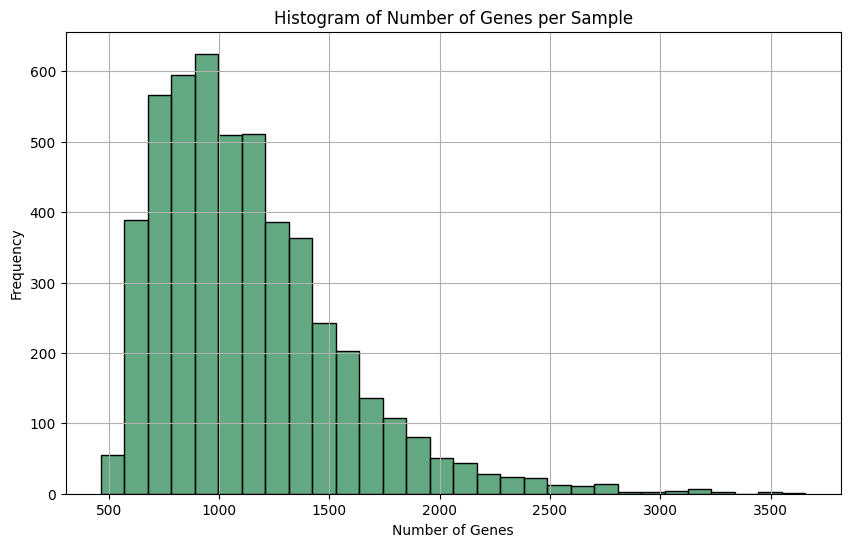

In [ ]:
#Create a new column for the length of expressions
pdf['expressions_length'] = pdf['expressions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(10, 6))
sns.histplot(pdf['expressions_length'], bins=30, kde=False, color='seagreen')
plt.title('Histogram of Number of Genes per Sample')
plt.xlabel('Number of Genes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram displays the distribution of the number of genes per sample across a dataset. The x-axis shows the number of genes (ranging from around 500 to 3500), while the y-axis represents frequency. The distribution is right-skewed with most samples containing between 800-1200 genes, peaking at approximately 1000 genes with a frequency of about 600 samples. The frequency gradually decreases as gene count increases, forming a long tail that extends to around 3500 genes. Very few samples contain more than 2500 genes. This pattern suggests that while there is some variability in gene expression across samples, the majority exhibit a similar range of active genes, with outliers having exceptionally high gene counts.

## **VISUALS**

<ipython-input-18-b5c6356d4281>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')


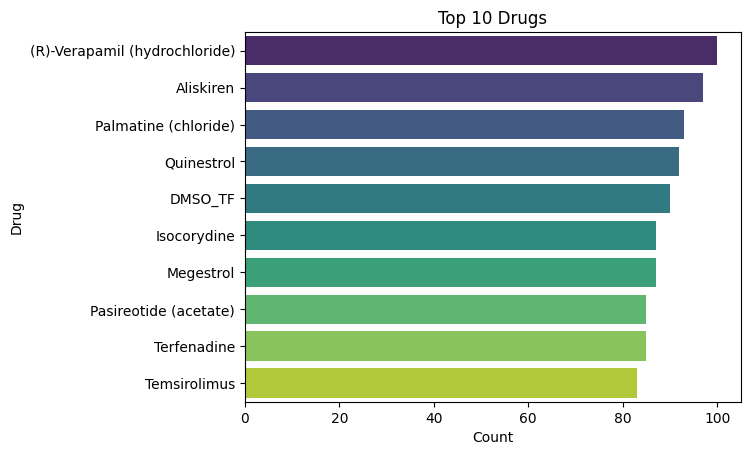

In [ ]:
pdf = df.limit(5000).toPandas()

# Plot distribution of expression values
import seaborn as sns
import matplotlib.pyplot as plt

top_drugs = pdf['drug'].value_counts().head(10)  # Top 10 drugs
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')
plt.title('Top 10 Drugs')
plt.xlabel('Count')
plt.ylabel('Drug')
plt.show()


The bar chart displays the top 10 most frequent drugs in the dataset.
(R)-Verapamil (hydrochloride) appears most frequently with approximately 100 counts, closely followed by Aliskiren with around 95 counts. The remaining drugs show a gradual decrease in frequency: Palmatine (chloride) and Quinestrol at roughly 90 counts each, DMSO_TF at about 85 counts, followed by Isocorydine, Megestrol, Pasireotide (acetate), Terfenadine, and Temsirolimus, with the latter having approximately 80 counts. The visualization illustrates the relative prevalence of these drugs in the analyzed sample, with a relatively small difference (about 20 counts) between the most and least frequent drugs in the top 10.

<ipython-input-19-b94150885818>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cell_lines.values, y=top_cell_lines.index, palette='magma')


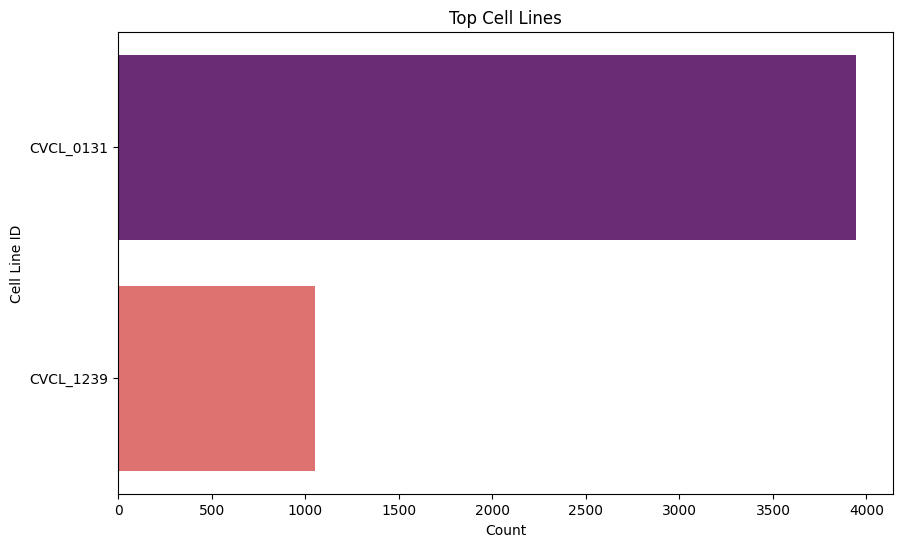

In [ ]:
plt.figure(figsize=(10, 6))
top_cell_lines = pdf['cell_line_id'].value_counts().head(10)
sns.barplot(x=top_cell_lines.values, y=top_cell_lines.index, palette='magma')
plt.title('Top Cell Lines')
plt.xlabel('Count')
plt.ylabel('Cell Line ID')
plt.show()


The bar chart shows the top cell lines distribution. CVCL_0131 dominates with approximately 4000 counts, while CVCL_1239 has only about 1000 counts. This four-fold difference highlights the overwhelming prevalence of CVCL_0131 in the dataset.

<ipython-input-20-d300c7728bce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_moa.values, y=top_moa.index, palette='cubehelix')


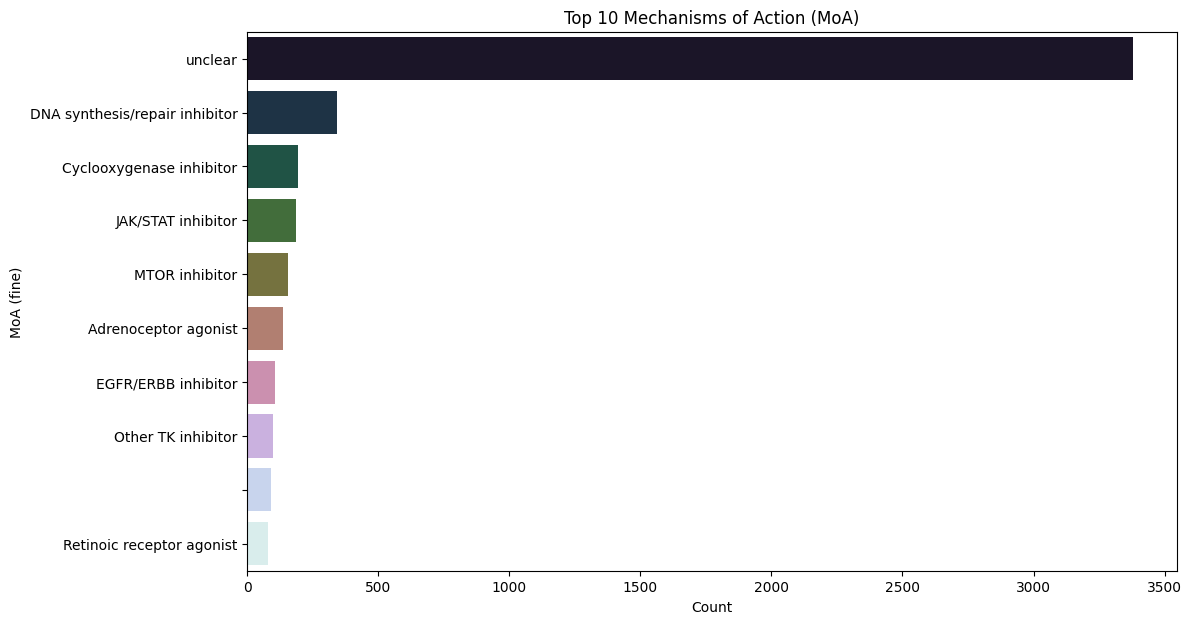

In [ ]:
plt.figure(figsize=(12, 7))
top_moa = pdf['moa-fine'].value_counts().head(10)
sns.barplot(x=top_moa.values, y=top_moa.index, palette='cubehelix')
plt.title('Top 10 Mechanisms of Action (MoA)')
plt.xlabel('Count')
plt.ylabel('MoA (fine)')
plt.show()


The bar chart shows the top 10 Mechanisms of Action (MoA). "Unclear" mechanisms overwhelmingly dominate with around 3200 counts, far surpassing all others. DNA synthesis/repair inhibitors follow at merely ~300 counts, with remaining mechanisms (Cyclooxygenase, JAK/STAT, mTOR inhibitors, and others) clustered between 50-200 counts. This stark distribution highlights the challenge of uncharacterized mechanisms in the dataset, with "unclear" classifications exceeding the next category by more than 10:1.

In [ ]:
#FOR LATER --Bring small sample to pandas for local inspection

# Convert hundred rows to pandas
pandas_df = df.limit(100).toPandas()

#quick pandas inspection
pandas_df.info()
pandas_df.describe(include="all")
pandas_df["drug"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BARCODE_SUB_LIB_ID  100 non-null    object
 1   canonical_smiles    100 non-null    object
 2   cell_line_id        100 non-null    object
 3   drug                100 non-null    object
 4   expressions         100 non-null    object
 5   genes               100 non-null    object
 6   moa-fine            100 non-null    object
 7   plate               100 non-null    object
 8   pubchem_cid         100 non-null    object
 9   sample              100 non-null    object
dtypes: object(10)
memory usage: 7.9+ KB


,count
drug,
Chlorhexidine (diacetate),32
Berbamine,22
8-Hydroxyquinoline,19
Trifluridine,18
Retinoic acid,9


# **EXPLORATION**

Here we see that the top cell lines have differential gene expression based on which drug they are treated with. Since they are cells from a similar origins (CVCL_0131 is glioblastoma and CVCL_1239 is from neuroglioma) there are significant overlaps in the number of genes expressed per drug treatment, however there are a significant group of drugs that are expressed differently between the two groups. This is likely due to them being from different individuals and coming from different cell lineages/phenotypes.

<ipython-input-29-46c91a26faa9>:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


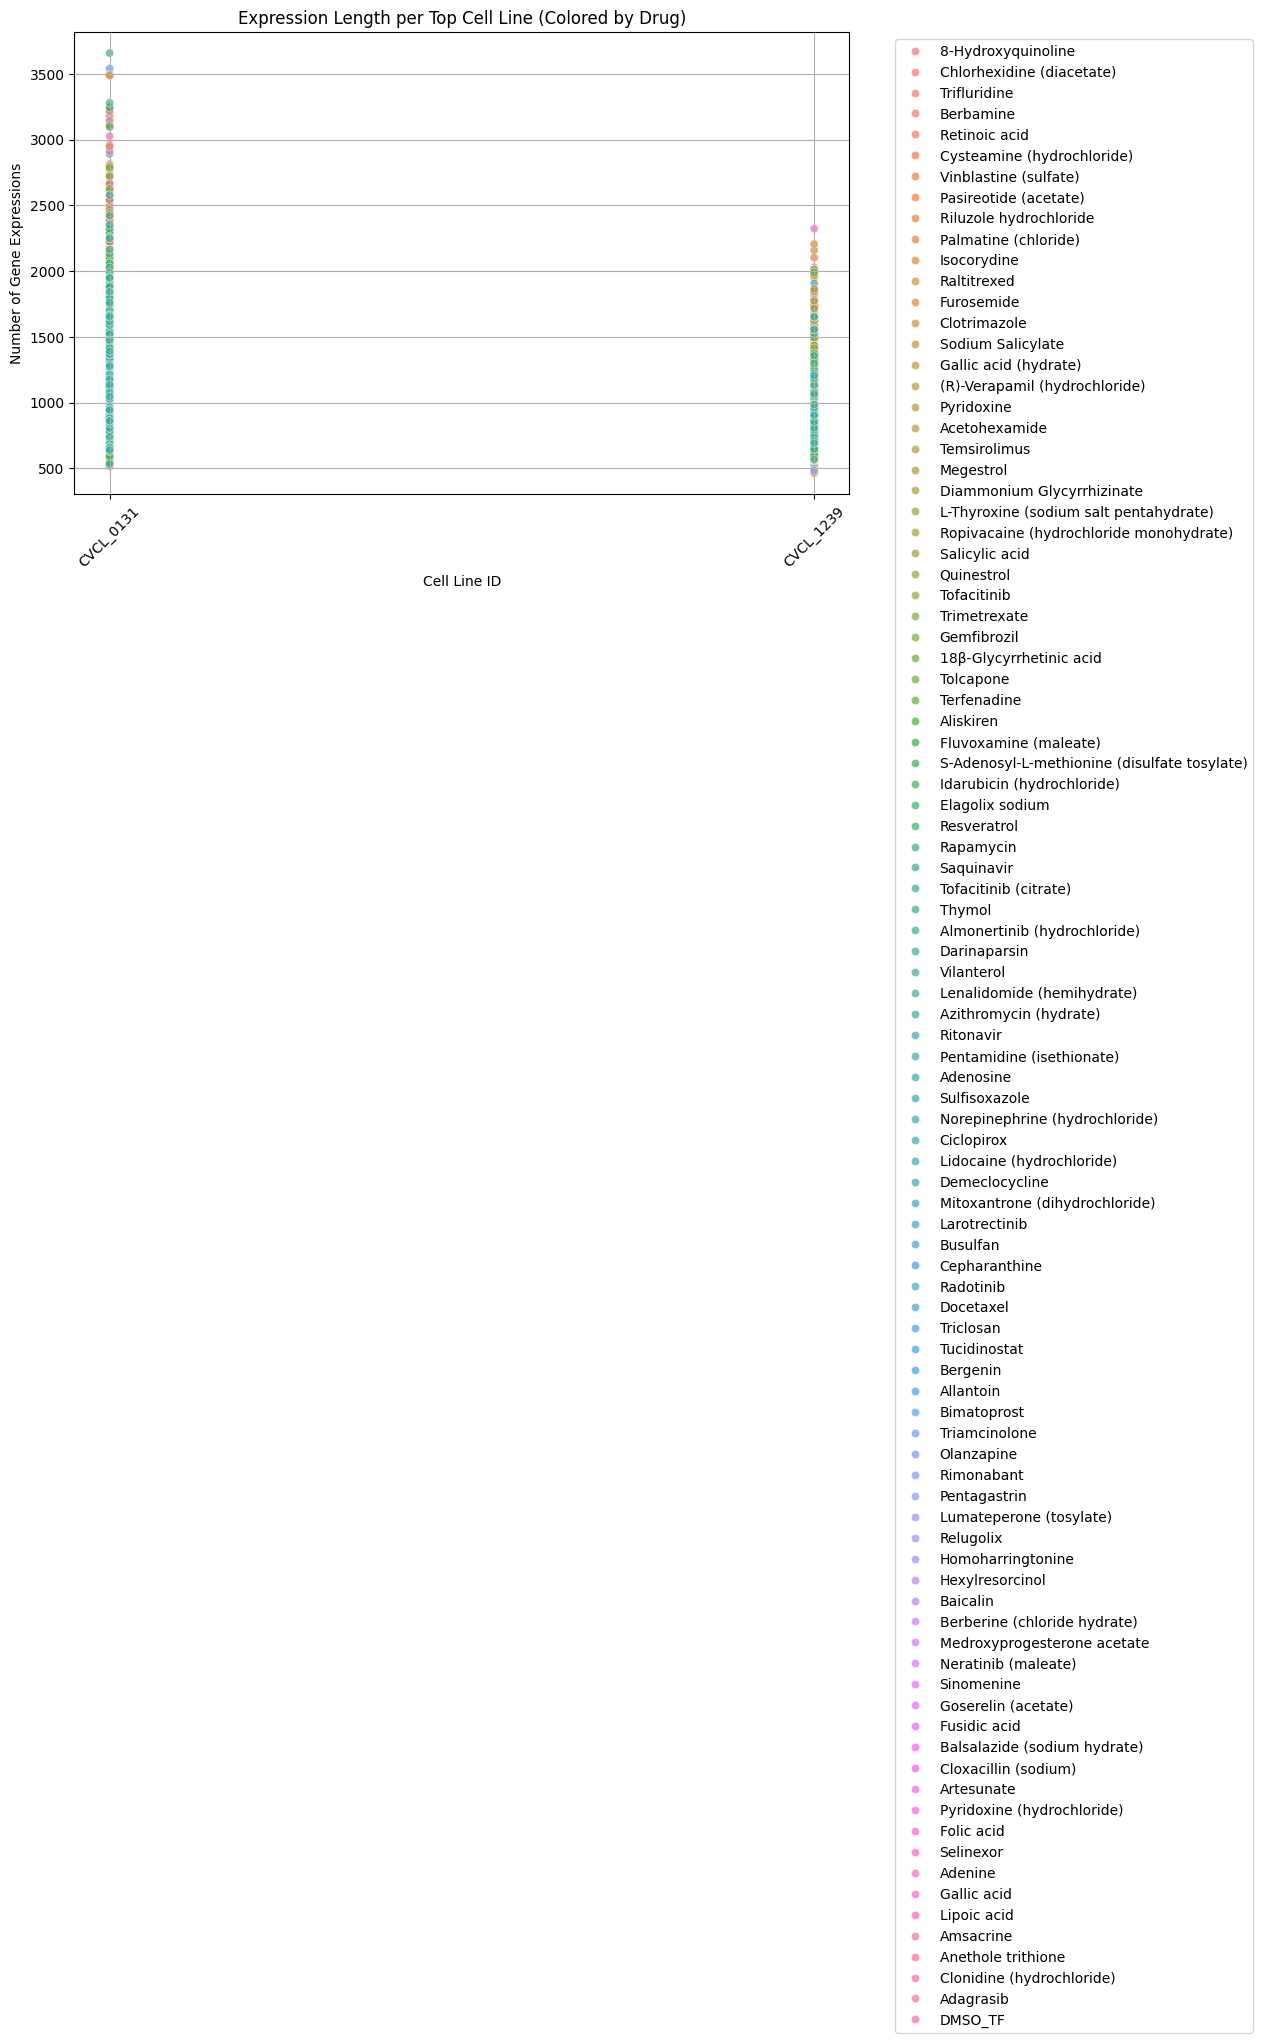

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot Expression Length vs. Cell Line
pdf['expressions_length'] = pdf['expressions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf, x='cell_line_id', y='expressions_length', hue='drug', alpha=0.7)
plt.title('Expression Length per Top Cell Line (Colored by Drug)')
plt.xticks(rotation=45)
plt.xlabel('Cell Line ID')
plt.ylabel('Number of Gene Expressions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


If we look closer at the mean expression of each cell line we can see a trend towards higher expression overall in the CVCL_0131 cell line. This means that, on any given drug treatment, it is likely to activate more genes in response to that treatment.

<ipython-input-31-78c1295b0c50>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x='cell_line_id', y='mean_expression', palette='pastel')


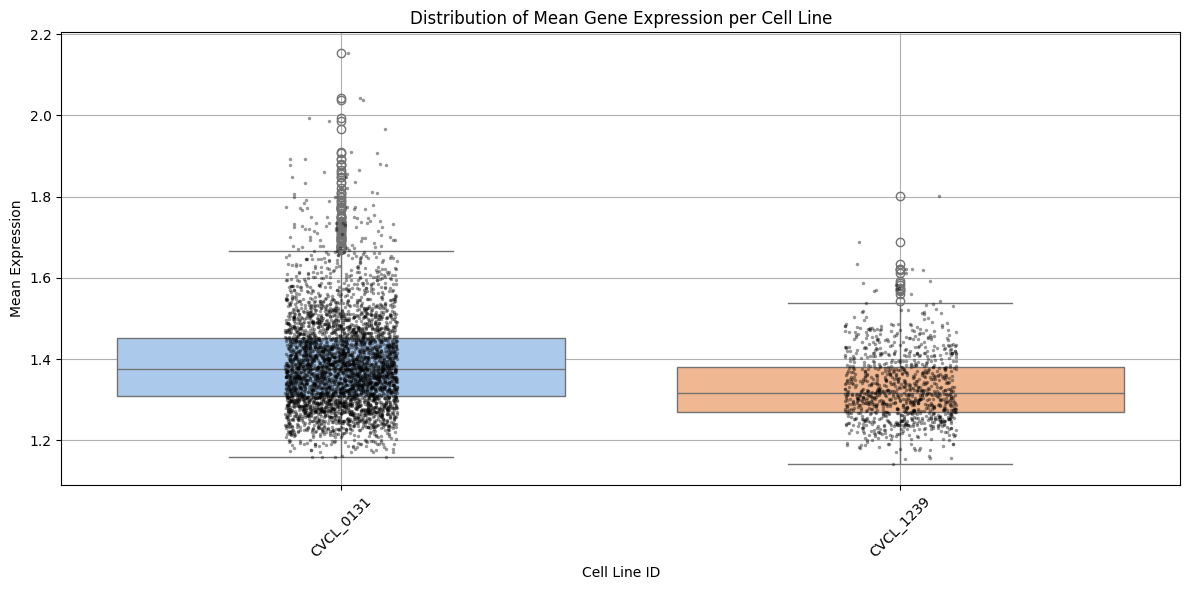

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean expression per sample
pdf['mean_expression'] = pdf['expressions'].apply(
    lambda x: sum(x)/len(x) if isinstance(x, list) and len(x) > 0 else 0
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=pdf, x='cell_line_id', y='mean_expression', palette='pastel')
sns.stripplot(data=pdf, x='cell_line_id', y='mean_expression',
              color='black', size=2.5, jitter=True, alpha=0.4)

plt.title('Distribution of Mean Gene Expression per Cell Line')
plt.xlabel('Cell Line ID')
plt.ylabel('Mean Expression')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


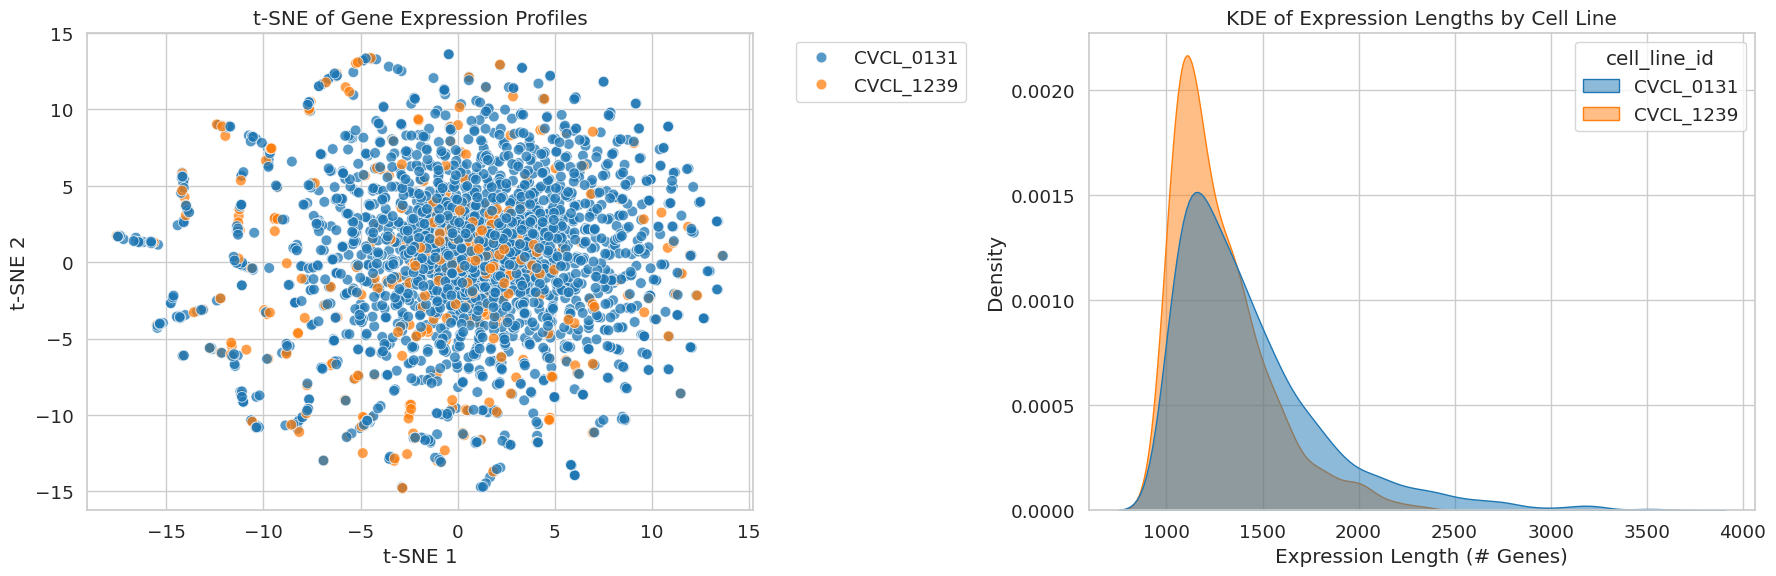

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Filter for valid samples with long enough expression vectors
valid_pdf = pdf[pdf['expressions'].apply(lambda x: isinstance(x, list) and len(x) >= 1000)].copy()

# Expression profile t-SNE
X_expr = np.array(valid_pdf['expressions'].apply(lambda x: x[:1000]).tolist())

tsne_expr = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embedding_expr = tsne_expr.fit_transform(X_expr)
valid_pdf['tsne_expr_1'] = embedding_expr[:, 0]
valid_pdf['tsne_expr_2'] = embedding_expr[:, 1]

# --- Expression Length Column for KDE ---
valid_pdf['expressions_length'] = valid_pdf['expressions'].apply(len)

# make a KDE AND a t-SNE (t-distributed Stochastic Neighbor Embedding; a high dimensional way of visualizing patterns)
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot t-SNE
sns.scatterplot(
    ax=axes[0],
    data=valid_pdf,
    x='tsne_expr_1',
    y='tsne_expr_2',
    hue='cell_line_id',
    palette='tab10',
    s=60,
    alpha=0.75
)
axes[0].set_title('t-SNE of Gene Expression Profiles')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot KDE of expression lengths
sns.kdeplot(
    ax=axes[1],
    data=valid_pdf,
    x='expressions_length',
    hue='cell_line_id',
    fill=True,
    common_norm=False,
    palette='tab10',
    alpha=0.5
)
axes[1].set_title('KDE of Expression Lengths by Cell Line')
axes[1].set_xlabel('Expression Length (# Genes)')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


If we plot the data side-by-side using high-dimensional t-SNE analysis we can visualize the differences and overlap in gene expression. Using a kernel density estimate for gene expression length also confirms similarities in the number of genes involved in drug interactions, however it also confirms what we saw earlier in the box plot that the density or mean expression of genes is shorter for CVCL_1239 versus CVCL_0131

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df.toPandas()

# per-cell mean
pdf['mean_expression'] = pdf['expressions'].map(
    lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x)>0 else 0
)

# baseline = mean of DMSO_TF within each line (DMSO_TF is the control)
baseline = (
    pdf[pdf['drug']=='DMSO_TF']
     .groupby('cell_line_id')['mean_expression']
     .mean()
     .rename('baseline')
)
pdf = pdf.join(baseline, on='cell_line_id')

# Δ mean expression
pdf['delta_mean'] = pdf['mean_expression'] - pdf['baseline']


# Plot first 7
first7 = list(pdf['drug'].unique())[:7]
pdf7 = pdf[pdf['drug'].isin(first7)]

# Boxplot
plt.figure(figsize=(14,6))
sns.boxplot(
    data=pdf7,
    x='drug',
    y='delta_mean',
    palette='pastel',
    showfliers=False
)
sns.stripplot(
    data=pdf7,
    x='drug',
    y='delta_mean',
    color='black',
    size=2,
    jitter=True,
    alpha=0.3
)
plt.title('Δ Mean Expression vs. DMSO_TF Control (First 7 Drugs)')
plt.xlabel('Drug')
plt.ylabel('Δ Mean Expression')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Each individual dot is one single cell, and its vertical position is that cell's Δ mean expression—i.e. how much that cell's overall gene expression shifted up (positive) or down (negative) compared to the mean expression of DMSO_TF control cells from the same cell line.

In [ ]:
# Compute average Δ per drug
avg_drug = (
    pdf
    .groupby('drug')['delta_mean']
    .mean()
    .reset_index()
    .rename(columns={'delta_mean':'avg_delta'})
    .sort_values('avg_delta', ascending=False)
)

# Plot Scatterplot
plt.figure(figsize=(20,10))
sns.scatterplot(
    data=avg_drug,
    x='drug',
    y='avg_delta',
    s=100,
    edgecolor='w'
)
plt.xticks(rotation=90)
plt.title('Average Δ Mean Expression per Drug')
plt.xlabel('Drug')
plt.ylabel('Average Δ Mean Expression')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.tight_layout()
plt.show()

This scatter shows, for each drug, the average change in mean gene expression (Δ mean) of all single cells treated with that drug, relative to their own DMSO_TF baseline.